# Feature Engineering & Prediction

## 0. Setup & Data Import

In [70]:
# import all the necessary libraries here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [338]:
# load the train and test data
# !! use a relative path so that we don't need to change it each time we run on a different computer

# load the training data
train_path = '../data/train.csv'
train_data = pd.read_csv(train_path)

# load the testing data
test_path = '../data/test-full.csv'
test_data = pd.read_csv(test_path)

In [199]:
# quickly visualise the datasets
print(train_data.shape)
print(test_data.shape)


(15120, 56)
(581012, 55)


In [200]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,0,0,0,0,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,0,0,0,0,0,0,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1


In [201]:
test_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


## 1.1. Feature Engineering

implemented so far (!!keep adding if you do stuff)

**Feature engineering**
- Scaling (need to check if this is relevant for the methods we used)
- Soil Types
- 


**Feature Selection**
- PCA
- 4 different classifiers
- Correlation rankings


### Scaling

In [232]:
## ++ to add?
# only necessary for KNN, other methods are not sensitive to scaling

### Soil Types

In [339]:
def soil_types(X: pd.DataFrame, drop_original: bool = False) -> pd.DataFrame:
    """
    This function aggregates the different soil types in the USFS Ecological
    Landtype Units description which encodes the following categories:
        1: stony
        2: rubly
        3: other
        
    Parameters:
    - X: pd.DataFrame - The input DataFrame containing soil type columns.
    - drop_original: bool - Indicates whether to drop the original soil type columns.
    
    Returns:
    - pd.DataFrame - The DataFrame with added aggregated soil type columns and optionally
                     without the original soil type columns.
    """
    X = X.copy()  # Work on a copy of the input DataFrame

    # Aggregate soil types into 'Soil_Stony'
    X["Soil_Stony"] = X.loc[
        :,
        X.columns.str.contains(
            "^Soil_Type[1269]$|^Soil_Type[1][28]$|^Soil_Type[2][456789]$|^Soil_Type[3][012346789]$"
        ),
    ].max(axis=1)
    
    # Aggregate soil types into 'Soil_Rubly'
    X["Soil_Rubly"] = X.loc[
        :,
        X.columns.str.contains("^Soil_Type[345]$|^Soil_Type[1][0123]$")
    ].max(axis=1)
    
    # Aggregate soil types into 'Soil_Other'
    X["Soil_Other"] = X.loc[
        :,
        X.columns.str.contains(
            "^Soil_Type[78]$|^Soil_Type[1][45679]$|^Soil_Type[2][0123]$"
        ),
    ].max(axis=1)

    # Drop original soil type columns if specified
    if drop_original:
        cols_to_drop = list(
            X.columns[X.columns.str.contains("^Soil_Type[0-9][0-9]$|^Soil_Type[0-9]$")]
        )
        X = X.drop(columns=cols_to_drop)

    return X


### Climate Zones

In [340]:
def climates(X: pd.DataFrame, drop_original: bool = False) -> pd.DataFrame:
    """
    This function aggregates the second digit of the USFS Ecological Landtype Units which
    encodes the following climatic zones:
        1: lower montane dry
        2: lower montane
        3: montane dry
        4: montane
        5: montane dry and montane
        6: montane and subalpine
        7: subalpine
        8: alpine
    The 'Id' column is preserved and reattached if present.
    
    Parameters:
    - X: pd.DataFrame - The input DataFrame.
    - drop_original: bool - Whether to drop the original soil type columns.
    
    Returns:
    - pd.DataFrame - The DataFrame with climatic zone columns added (and potentially soil type columns removed),
      with the 'Id' column reattached (if it was present).
    """
    X = X.copy()  # Modify a copy of X to avoid changing the original DataFrame
    
    # Store the 'Id' column if it exists, then remove it temporarily
    if 'Id' in X.columns:
        Id_col = X['Id'].copy()
        X.drop(columns=['Id'], inplace=True)
    else:
        Id_col = None

    # Climatic Zones aggregation based on soil types
    X["Clim2"] = X.loc[:, X.columns.str.contains("^Soil_Type[1-6]$")].max(axis=1)
    X["Clim3"] = X.loc[:, X.columns.str.contains("^Soil_Type[78]$")].max(axis=1)
    X["Clim4"] = X.loc[:, X.columns.str.contains("^Soil_Type[1][0-3]$|Soil_Type9")].max(axis=1)
    X["Clim5"] = X.loc[:, X.columns.str.contains("^Soil_Type[1][45]$")].max(axis=1)
    X["Clim6"] = X.loc[:, X.columns.str.contains("^Soil_Type[1][678]$")].max(axis=1)
    X["Clim7"] = X.loc[:, X.columns.str.contains("^Soil_Type19$|^Soil_Type[2][0-9]$|^Soil_Type[3][0-4]$")].max(axis=1)
    X["Clim8"] = X.loc[:, X.columns.str.contains("^Soil_Type[3][56789]$|Soil_Type40")].max(axis=1)

    # Drop original soil type columns if requested
    if drop_original:
        cols_to_drop = list(X.columns[X.columns.str.contains("^Soil_Type[0-9][0-9]$|^Soil_Type[0-9]$")])
        X = X.drop(columns=cols_to_drop)
    
    # Reattach the 'Id' column if it was present
    if Id_col is not None:
        X = pd.concat([Id_col.reset_index(drop=True), X], axis=1)
    
    return X


### Linear Distance

In [341]:
def linear_dist(X: pd.DataFrame, drop_original: bool = False) -> pd.DataFrame:
    """
    This function calculates linear combinations of distances to hydrology,
    fire points, and roadways, including:
        - hydrology + fire points
        - |hydrology - fire points|
        - hydrology + roadways
        - |hydrology - roadways|
        - fire points + roadways
        - |fire points - roadways|
        
    The 'Id' column is preserved and reattached if present.
    
    Parameters:
    - X: pd.DataFrame - The input DataFrame containing distance columns and optionally an 'Id' column.
    - drop_original: bool - Indicates whether to drop the original distance columns after calculating the combinations.
    
    Returns:
    - pd.DataFrame - The DataFrame with added linear combination columns and optionally without the original distance columns.
    """
    X = X.copy()  # Work on a copy of the input DataFrame to avoid changing the original
    
    # Store the 'Id' column if it exists, then remove it temporarily
    if 'Id' in X.columns:
        Id_col = X['Id'].copy()
        X.drop(columns=['Id'], inplace=True)
    else:
        Id_col = None

    # List of distance columns to combine
    cols = [
        "Horizontal_Distance_To_Hydrology",
        "Horizontal_Distance_To_Fire_Points",
        "Horizontal_Distance_To_Roadways",
    ]

    # Linear Combination of distances
    X["Hyd_p_Fire"] = X[cols[0]] + X[cols[1]]
    X["Hyd_m_Fire"] = abs(X[cols[0]] - X[cols[1]])
    X["Hyd_p_Road"] = X[cols[0]] + X[cols[2]]
    X["Hyd_m_Road"] = abs(X[cols[0]] - X[cols[2]])
    X["Fire_p_Road"] = X[cols[1]] + X[cols[2]]
    X["Fire_m_Road"] = abs(X[cols[1]] - X[cols[2]])

    # Drop the original distance columns if specified
    if drop_original:
        X.drop(columns=cols, inplace=True)

    # Reattach the 'Id' column if it was present
    if Id_col is not None:
        X = pd.concat([Id_col, X], axis=1)

    return X


### Euclidian Distance

In [342]:
# Calculate new features based on mean distances
# train
train_data['Mean_Elevation_Vertical_Distance_Hydrology'] = (train_data['Elevation'] + train_data['Vertical_Distance_To_Hydrology']) / 2
train_data['Mean_Distance_Hydrology_Firepoints'] = (train_data['Horizontal_Distance_To_Hydrology'] + train_data['Horizontal_Distance_To_Fire_Points']) / 2
train_data['Mean_Distance_Hydrology_Roadways'] = (train_data['Horizontal_Distance_To_Hydrology'] + train_data['Horizontal_Distance_To_Roadways']) / 2
train_data['Mean_Distance_Firepoints_Roadways'] = (train_data['Horizontal_Distance_To_Fire_Points'] + train_data['Horizontal_Distance_To_Roadways']) / 2

print(f"Shape of train after adding new features: {train_data.shape}")

# test
test_data['Mean_Elevation_Vertical_Distance_Hydrology'] = (test_data['Elevation'] + test_data['Vertical_Distance_To_Hydrology']) / 2
test_data['Mean_Distance_Hydrology_Firepoints'] = (test_data['Horizontal_Distance_To_Hydrology'] + test_data['Horizontal_Distance_To_Fire_Points']) / 2
test_data['Mean_Distance_Hydrology_Roadways'] = (test_data['Horizontal_Distance_To_Hydrology'] + test_data['Horizontal_Distance_To_Roadways']) / 2
test_data['Mean_Distance_Firepoints_Roadways'] = (test_data['Horizontal_Distance_To_Fire_Points'] + test_data['Horizontal_Distance_To_Roadways']) / 2

print(f"Shape of test after adding new features: {test_data.shape}")


Shape of train after adding new features: (15120, 60)
Shape of test after adding new features: (581012, 59)


### Apply functions

In [343]:
# soil fct
train_data = soil_types(train_data)
test_data = soil_types(test_data)

# climate fct
train_data = climates(train_data)
test_data = climates(test_data)

# linear distance fct
train_data = linear_dist(train_data)
test_data = linear_dist(test_data)

In [319]:
# train data post-feature engineering -> make sure it still contains 'Id'
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Clim5,Clim6,Clim7,Clim8,Hyd_p_Fire,Hyd_m_Fire,Hyd_p_Road,Hyd_m_Road,Fire_p_Road,Fire_m_Road
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,0,1,0,552,132,1230,810,1362,678
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,1,0,1084,600,1613,1129,2213,529
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,1,0,2636,1400,1710,474,3110,926
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,1,0,1909,587,1413,91,2000,496
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,1,0,2848,2498,3880,3530,6378,1032


## 1.2. Feature Selection

Now that we have determined how to change our features or add new meaningful features, we select the most important ones to keep for our prediction. There are several options to select our features, including:
- PCA
- Using classifiers from sklearn.ensemble Library to rank the features by meaningfulness
- Removing the ones with lowest correlation to Cover Type

These methods lead to slightly rankings, however the most important features accross methods are consistent across methods.

### PCA

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y = train_data['Cover_Type'] 
X = train_data.drop('Cover_Type', axis=1) 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
pca = PCA(n_components=20) 
X_pca = pca.fit_transform(X_scaled)

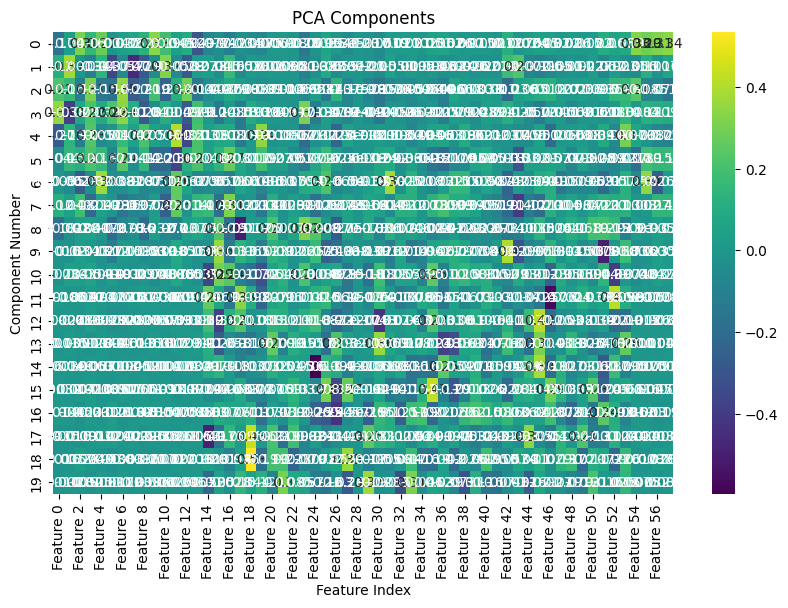

In [287]:
components_df = pd.DataFrame(pca.components_, columns=[f'Feature {i}' for i in range(X_scaled.shape[1])])

plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap='viridis', annot=True)
plt.title('PCA Components')
plt.ylabel('Component Number')
plt.xlabel('Feature Index')
plt.show()


The main drawback is that PCA is not very interpretable, so we look at various classifier rankings next.

### Classifier Rankings

Random Forest Classifier

In [360]:
X = train_data.drop(['Id', 'Cover_Type'], axis=1) 
y = train_data['Cover_Type']

# train random forest
RFC_model = RandomForestClassifier(random_state=0, n_jobs=-1)
RFC_model.fit(X, y)

# Extract feature importance
importances = RFC_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Get feature names and their importances
rfc_list = [X.columns[indices[f]] for f in range(X.shape[1])]
rfci_list = [importances[indices[f]] for f in range(X.shape[1])]

ranking_rfc = pd.DataFrame({
    'RFC': rfc_list,
    'RFC Importance': rfci_list
})

ranking_rfc.head(10)


,RFC,RFC Importance
0,Elevation,0.128301
1,Mean_Elevation_Vertical_Distance_Hydrology,0.102085
2,Fire_p_Road,0.039116
3,Mean_Distance_Firepoints_Roadways,0.037360
4,Horizontal_Distance_To_Roadways,0.036205
5,Hyd_m_Road,0.034825
6,Horizontal_Distance_To_Hydrology,0.033296
7,Hyd_p_Road,0.032271
8,Mean_Distance_Hydrology_Roadways,0.031388
9,Wilderness_Area4,0.030297


Extra Trees Classifier

In [361]:
from sklearn.ensemble import ExtraTreesClassifier

ETC_model = ExtraTreesClassifier(random_state=0, n_jobs=-1)
ETC_model.fit(X, y)

importances = ETC_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Get feature names and their importances
etc_list = [X.columns[indices[f]] for f in range(X.shape[1])]
etci_list = [importances[indices[f]] for f in range(X.shape[1])]

ranking_etc = pd.DataFrame({
    'ETC': etc_list,
    'ETC Importance': etci_list
})

ranking_etc.head(10)


,ETC,ETC Importance
0,Elevation,0.086044
1,Mean_Elevation_Vertical_Distance_Hydrology,0.064333
2,Clim8,0.052328
3,Wilderness_Area4,0.041624
4,Mean_Distance_Firepoints_Roadways,0.034612
5,Fire_p_Road,0.032821
6,Hyd_m_Road,0.032212
7,Mean_Distance_Hydrology_Roadways,0.031815
8,Horizontal_Distance_To_Roadways,0.031497
9,Clim7,0.031430


Gradient Boosting Classifier

In [363]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier(random_state=0)
GBC_model.fit(X, y)

# Extract Feature Importance
importances = GBC_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Get feature names and their importances
gbc_list = [X.columns[indices[f]] for f in range(X.shape[1])]
gbci_list = [importances[indices[f]] for f in range(X.shape[1])]

ranking_gbc = pd.DataFrame({
    'GBC': gbc_list,
    'GBC Importance': gbci_list
})

ranking_gbc.head(10)


,GBC,GBC Importance
0,Elevation,0.443209
1,Clim8,0.066944
2,Soil_Type10,0.056028
3,Clim7,0.046358
4,Hillshade_9am,0.037497
5,Hyd_m_Road,0.031692
6,Horizontal_Distance_To_Hydrology,0.031614
7,Soil_Type30,0.027442
8,Fire_m_Road,0.025475
9,Soil_Type12,0.022215


AdaBoost

In [364]:
from sklearn.ensemble import AdaBoostClassifier

ABC_model = AdaBoostClassifier(random_state=0)
ABC_model.fit(X, y)

# extract feature importance
importances = ABC_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Get feature names and their importances
abc_list = [X.columns[indices[f]] for f in range(X.shape[1])]
abci_list = [importances[indices[f]] for f in range(X.shape[1])]

ranking_ada = pd.DataFrame({
    'ABC': abc_list,
    'ABC Importance': abci_list
})

ranking_ada.head(10)

,ABC,ABC Importance
0,Wilderness_Area4,0.48
1,Mean_Elevation_Vertical_Distance_Hydrology,0.46
2,Elevation,0.06
3,Soil_Type12,0.00
4,Soil_Type6,0.00
5,Soil_Type7,0.00
6,Soil_Type8,0.00
7,Soil_Type9,0.00
8,Soil_Type10,0.00
9,Soil_Type11,0.00


### Correlation coefficients

In [325]:
correlation_matrix = train_data.corr()  # Compute the correlation matrix

# Calculate the correlation of each feature with 'Cover_Type'
feature_correlation = correlation_matrix['Cover_Type'].drop(['Cover_Type', 'Id'])  # Exclude self-correlation and Id
ranking_corr = feature_correlation.abs().sort_values(ascending=False)

# Print the ranking of features based on their absolute correlation with 'Cover_Type'
print("Ranking of features by absolute correlation with 'Cover_Type':")
print(ranking_corr)

# Decide on a threshold for low correlation and identify low correlation features
low_correlation_features = ranking_corr[ranking_corr < 0.05].index.tolist()

print("\nFeatures with low correlation (absolute value < 0.05):")
print(low_correlation_features)

Ranking of features by absolute correlation with 'Cover_Type':
Clim8               0.436913
Clim7               0.409168
Soil_Type38         0.254248
Soil_Type39         0.234777
Wilderness_Area1    0.229981
                      ...   
Soil_Type11         0.004247
Clim2               0.004088
Soil_Type26         0.002939
Soil_Type34         0.002877
Soil_Type15              NaN
Name: Cover_Type, Length: 74, dtype: float64

Features with low correlation (absolute value < 0.05):
['Soil_Type19', 'Clim6', 'Hillshade_3pm', 'Soil_Type17', 'Soil_Type20', 'Soil_Type5', 'Soil_Type21', 'Soil_Type13', 'Soil_Type4', 'Soil_Type14', 'Clim5', 'Wilderness_Area2', 'Mean_Elevation_Vertical_Distance_Hydrology', 'Soil_Type25', 'Soil_Type36', 'Soil_Type27', 'Soil_Type3', 'Clim3', 'Soil_Type9', 'Soil_Type1', 'Soil_Type8', 'Soil_Type16', 'Hillshade_9am', 'Elevation', 'Soil_Type18', 'Soil_Type28', 'Soil_Type2', 'Aspect', 'Soil_Type7', 'Soil_Type6', 'Soil_Type30', 'Horizontal_Distance_To_Hydrology', 'Soil_Typ

### Features to keep

Chose only one of the options below!

Option 1: Handpick features

In [366]:
hp_features = ['Elevation', 
               'Wilderness_Area4', 
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 
               'Soil_Type2','Soil_Type4', 'Soil_Type10', 'Soil_Type22', 'Soil_Type23', 'Soil_Type39',
               'Fire_p_Road', 'Hyd_m_Road', 'Hyd_p_Road',
                'Mean_Distance_Firepoints_Roadways', 'Mean_Elevation_Vertical_Distance_Hydrology', 'Mean_Distance_Hydrology_Roadways',
                'Clim6', 'Clim7', 'Clim8']


train_features = hp_features + ['Cover_Type'] + ['Id']
test_features = hp_features + ['Id']

train = train_data[train_features]
test = test_data[test_features]


Option 2:  combine all the rankings created above and select the features that appear in at least one of the rankings' top 10 features.

In [374]:
# Keep the top 10 of each ranking/method
top10_rf = set(ranking_rfc['RFC'].head(10))
top10_et = set(ranking_etc['ETC'].head(10))
top10_gb = set(ranking_gbc['GBC'].head(10))
top10_ab = set(ranking_ada['ABC'].head(10))
top10_corr = ranking_corr.head(10).index.tolist()

# Combine the sets to get unique features from the top 10 of any classifier
unique_top_features = top10_rf.union(top10_et).union(top10_gb).union(top10_ab).union(top10_corr)
unique_top_features

{'Clim7',
 'Clim8',
 'Elevation',
 'Fire_m_Road',
 'Fire_p_Road',
 'Hillshade_9am',
 'Horizontal_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hyd_m_Road',
 'Hyd_p_Road',
 'Mean_Distance_Firepoints_Roadways',
 'Mean_Distance_Hydrology_Roadways',
 'Mean_Elevation_Vertical_Distance_Hydrology',
 'Soil_Other',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type22',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40',
 'Soil_Type6',
 'Soil_Type7',
 'Soil_Type8',
 'Soil_Type9',
 'Wilderness_Area1',
 'Wilderness_Area4'}

In [375]:
unique_top_features_list = list(unique_top_features)

train_features = unique_top_features_list + ['Cover_Type'] + ['Id']
test_features = unique_top_features_list + ['Id']

train = train_data[train_features]
test = test_data[test_features]

Option 3: Pick the features with PCA

In [ ]:
# ++

# 2. Prediction

++ for our report: create a fct where we can compare all of our scores (e.g. creates a matrix with all the different scores)

In [376]:
# check what the train and test shapes looks like with feature engineering implemented
# train should have one more column (the Cover_Type) compared to test
print(train.shape) 
print(test.shape)


(15120, 31)
(581012, 30)


### Train the model(s)

Split the datasets for validation

In [377]:
# Prepare the data for the prediction
X = train.drop(['Id', 'Cover_Type'], axis=1)
y = train['Cover_Type']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Classifier

In [378]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=17)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf_model.predict(X_val)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred)
print(f'Random Forest Accuracy: {accuracy_rf}')


Random Forest Accuracy: 0.8756613756613757


Gradient Boosting Classifier

In [371]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=17)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_gb = gb_model.predict(X_val)

# Evaluate the model
accuracy_gb = accuracy_score(y_val, y_pred_gb)
print(f'Gradient Boosting Classifier Accuracy: {accuracy_gb}')


Gradient Boosting Classifier Accuracy: 0.7847222222222222


KNN

In [372]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(weights='distance', n_jobs=-1, n_neighbors=2)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_knn = knn_model.predict(X_val)

# Evaluate the model
accuracy_knn = accuracy_score(y_val, y_pred_knn)
print(f'K-Nearest Neighbors Classifier Accuracy: {accuracy_knn}')


K-Nearest Neighbors Classifier Accuracy: 0.7820767195767195


XGBoost

In [373]:
# XGboost uses a special indexing, which is why we do the prediction and CSV output here directly for this method.

# adjust indexing
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(random_state=5, use_label_encoder=False, eval_metric='logloss')

# Train the model using the adjusted labels
xgb_model.fit(X_train, y_train_adjusted)

# Predict on the validation set using the adjusted labels
y_pred_xgb = xgb_model.predict(X_val)

# Since predictions will also be in the adjusted label space, you need to add 1 back to align with the original labeling
y_pred_xgb_original_labels = y_pred_xgb + 1

# Evaluate the model
accuracy_xgb = accuracy_score(y_val_adjusted, y_pred_xgb)
print(f'XGBoost Classifier Accuracy: {accuracy_xgb}')

# Prepare the test data by removing the 'Id' column
X_test = test.drop(['Id'], axis=1) 

# Predict on the test data using the XGBoost model
test_predictions_adjusted = xgb_model.predict(X_test)

# Adjust the predictions back to the original label range for submission
test_predictions = test_predictions_adjusted + 1

# Create a DataFrame with 'Id' and 'Cover_Type' columns
prediction_df = pd.DataFrame({
    'Id': test['Id'],  
    'Cover_Type': test_predictions
})

# Save the DataFrame to a CSV file for submission
prediction_filename = 'XGBoost_predictions.csv'
prediction_df.to_csv(prediction_filename, index=False)

XGBoost Classifier Accuracy: 0.8406084656084656


SVM Classifier

In [334]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM Classifier
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_svm = svm_model.predict(X_val)

# Evaluate the model
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f'Support Vector Machine Classifier Accuracy: {accuracy_svm}')


Support Vector Machine Classifier Accuracy: 0.6087962962962963


### Create the CSV file

Your submission should be a CSV file with 581012 rows and a header. 

In [379]:
# Prepare the test data by removing the 'Id' column
X_test = test.drop(['Id'], axis=1)

# Predict on the test data
# !! change the model name according to what you are using
test_predictions = rf_model.predict(X_test)

# Create a DataFrame with 'Id' and 'Cover_Type' columns
prediction_df = pd.DataFrame({
    'Id': test['Id'],
    'Cover_Type': test_predictions
})

# Save the DataFrame to a CSV file
prediction_filename = 'predictions.csv'
prediction_df.to_csv(prediction_filename, index=False)

In [61]:
# run this for debugging: it should output (581012, 2). Otherwise the format is wrong.
prediction_df.shape

(581012, 2)

## Scorekeeping

To keep track of our Kaggle scores, every time you submit a new csv to kaggle, add the score + a short description of what we changed/added

Use Format: Score obtained on kaggle / Feature Engineering Steps Used / Model Used
!! keep in order of biggest to smallest scores

**Random Forest**
- 0.75 / Euclidian Dist + Keeping union of top 10 most meaningful values / Random Forest
- 0.74 / Euclidian Dist + Keeping intersection of top 20 most meaningful values / Random Forest
- 0.73 / Euclidian Dist + Keeping union of top 5 most meaningful values / Random Forest
- 0.68 / Euclidian Dist, Low Corr(0.05), Merge Soil Types / Random Forest
- 0.50 / Interaction Fct, Aggregate Fct, Euclidian Dist, Low Corr(0.05), Merge Soil Types / Random Forest


**Gradient Boosting Classifier**
- 0.65 / Euclidian Dist, Low Corr(0.02) / GBC
- 0.56 / Euclidian Dist, Low Corr(0.05), Merge Soil Types / GBC
- 0.55 / Euclidian Dist, Low Corr(0.05) / GBC

**KNN**
- 0.65 / Euclidian Dist + Keeping intersection of top 20 most meaningful values / KNN w 2 neighors

-**XGBoost**
- 0.74 / Euclidian Dist
- 0.73 / no Feature Eng



# 3. Hyperparameter Tuning

In [337]:
# ++ to do for the best 2-3 models

# 4. Archives

Drag code here that might be useful later but that currently does not work/ cannot be used

In [338]:
## gives very bad accuracy scores (around 0.3) for all the algos, so sth is wrong

# test model


from ast import literal_eval
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score



def evaluate_models(X, y):
    models = {
        "LogReg": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(),
        "DT": DecisionTreeClassifier(),
        "RF": RandomForestClassifier(),
        "ExtraTrees": ExtraTreesClassifier(),
        "XGB": XGBClassifier(),
        "Catboost": CatBoostClassifier(verbose=0),
        #"LightGBM": LGBMClassifier(),
    }
    
    results = {}
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy') 
        results[name] = scores
        print(f"{name}: Accuracy = {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    return results

### Merging Soil Types

not sure it makes sense to keep this one

In [361]:
# Extract soil type columns
soil_columns = [col for col in train.columns if col.startswith('Soil_Type')]

# Combine the soil type columns into a single feature by identifying the active soil type
# train
train['Soil_Type_Combined'] = train[soil_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)
train = train.drop(soil_columns, axis=1)

# test
test['Soil_Type_Combined'] = test[soil_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)
test = test.drop(soil_columns, axis=1)


### Aggregate Features

In [6]:
def create_aggregate_features(df):
    """
    Create aggregate features that summarize information across multiple features.

    Args:
        df (pd.DataFrame): DataFrame to enhance with aggregate features.

    Returns:
        pd.DataFrame: DataFrame with new aggregate features.
    """
    # Example aggregate feature: Mean Hillshade
    df['Mean_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)

    # More aggregates can be added based on exploratory data analysis and domain knowledge


    return df


### Interaction Features

In [ ]:
def create_interaction_features(df):
    """
    Create interaction features by combining existing features.

    Args:
        df (pd.DataFrame): DataFrame to enhance with interaction features.

    Returns:
        pd.DataFrame: DataFrame with new interaction features.
    """
    # Example interaction: Elevation and Hydrology features
    df['Elevation_plus_Vertical_Hydrology'] = df['Elevation'] + df['Vertical_Distance_To_Hydrology']
    df['Elevation_times_Horizontal_Hydrology'] = df['Elevation'] * df['Horizontal_Distance_To_Hydrology']

    # You can add more interactions based on domain knowledge and exploratory data analysis insights

    return df


### Polynomial Features

In [ ]:
# this fct does not seem to work when applied to train_data -> look into this
from sklearn.preprocessing import PolynomialFeatures

def add_polynomial_features(df, feature_cols, degree=2):
    """
    Adds polynomial features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to enhance with polynomial features.
        feature_cols (list): List of column names to which polynomial features will be applied.
        degree (int): The degree of the polynomial features.

    Returns:
        pd.DataFrame: DataFrame with polynomial features added.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[feature_cols])
    poly_feature_names = poly.get_feature_names(feature_cols)
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    
    # Drop the original features to avoid multicollinearity
    df.drop(feature_cols, axis=1, inplace=True)
    
    # Concatenate the original DataFrame with the new polynomial features
    df = pd.concat([df, df_poly], axis=1)
    
    return df
